In [1]:
import scipy.misc
import numpy as np
import tensorflow as tf
import IPython.display
import PIL.Image
from cStringIO import StringIO
from datetime import datetime

In [2]:
#!wget -O - http://www.cs.toronto.edu/~frossard/vgg16/vgg16_weights.npz > vgg16_weights.npz 

In [3]:
import vgg16
network_model = vgg16

In [4]:
content_layer = network_model.content_layers()
style_layer = network_model.style_layers()

In [5]:
iterations=1000
content_weight = 1e0
style_weight = 1e3
tv_weight = 0
learning_rate = 1e0
style_weight_layer = style_weight / len(style_layer)

In [6]:
style_image = 'styles/starry-night.jpg'
content_image = 'inputs/london.jpg'

In [ ]:
def display_array(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [7]:
def load_image(img_path, new_size=None):
    loaded = scipy.misc.imread(img_path).astype(np.float)

    # grayscale to rgb
    if len(loaded.shape) == 2:
        loaded = np.dstack([loaded, loaded, loaded])

    # rescale if needed
    if new_size:
        h,w,c = loaded.shape
        if h > w:
            ratio = w/float(h)
            shape = (new_size, int(new_size*ratio))
        else:
            ratio = h/float(w)
            shape = (int(new_size*ratio), new_size)
        loaded = scipy.misc.imresize(loaded, shape)

    return loaded

In [8]:
def get_name(image):
    return image.split('/')[1].split('.')[0]

out_image_name = get_name(content_image)+'_'+get_name(style_image)+'_style.jpg'
print(out_image_name)

london_starry-night_style.jpg


In [9]:
def content_loss(cont_out, target_out, layer, content_weight):
    '''
        # content loss is just the mean square error between the outputs of a given layer
        # in the content image and the target image
    '''
    cont_loss = tf.reduce_sum(tf.square(tf.subtract(target_out[layer], cont_out)))

    # multiply the loss by it's weight
    cont_loss = tf.multiply(cont_loss, content_weight, name="cont_loss")

    return cont_loss

In [10]:
def get_shape(inp):
    # returns the shape of a tensor or an array
    if type(inp) == type(np.array([])):
        return inp.shape
    else:
        return [i.value for i in inp.get_shape()]

In [11]:
def style_loss(style_out, target_out, layers, style_weight_layer):

    def style_layer_loss(style_out, target_out, layer):
        '''
            # returns the style loss for a given layer between
            # the style image and the target image
        '''
        def gram_matrix(activation):
            flat = tf.reshape(activation, [-1, get_shape(activation)[3]]) # shape[3] is the number of feature maps
            res = tf.matmul(flat, flat, transpose_a=True)
            return res

        N = get_shape(target_out[layer])[3] # number of feature maps
        M = get_shape(target_out[layer])[1] * get_shape(target_out[layer])[2] # dimension of each feature map
        
        # compute the gram matrices of the activations of the given layer
        style_gram = gram_matrix(style_out[layer])
        target_gram = gram_matrix(target_out[layer])

        st_loss = tf.multiply(tf.reduce_sum(tf.square(tf.subtract(target_gram, style_gram))), 1./((N**2) * (M**2)))

        # multiply the loss by it's weight
        st_loss = tf.multiply(st_loss, style_weight_layer, name='style_loss')

        #tf.add_to_collection('losses', st_loss)
        return st_loss

    losses = []
    for s_l in layers:
        loss = style_layer_loss(style_out, target_out, s_l)
        losses.append(loss)

    return losses

In [12]:
def total_var_loss(generated, tv_weight):
    ''' 
        Computes the total variation loss of the generated image
    '''
    batch, width, height, channels = get_shape(generated)

    width_var = tf.nn.l2_loss(tf.subtract(generated[:,:width-1,:,:], generated[:,1:,:,:]))
    height_var = tf.nn.l2_loss(tf.subtract(generated[:,:,:height-1,:], generated[:,:,1:,:]))

    return tv_weight*tf.add(width_var, height_var)

In [13]:
content = load_image(content_image, new_size=None)
style = load_image(style_image, new_size=None)

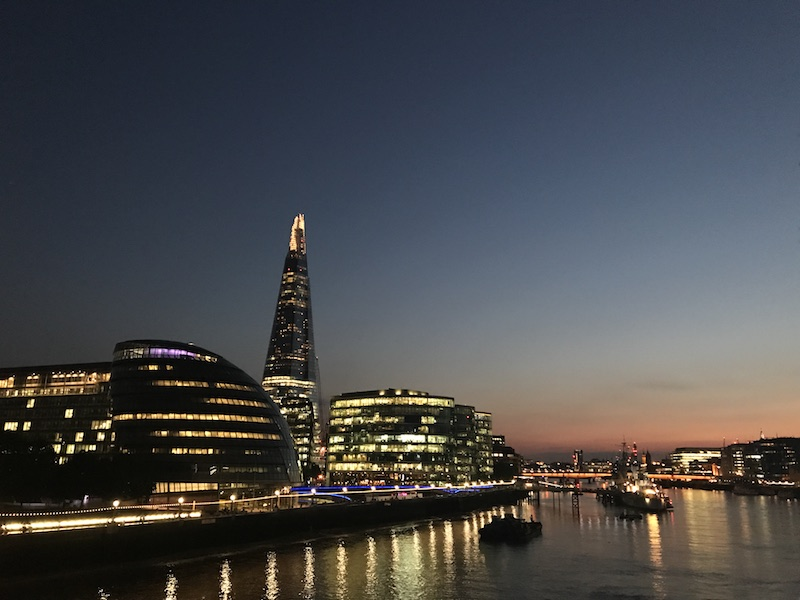

In [28]:
 display_array(content)

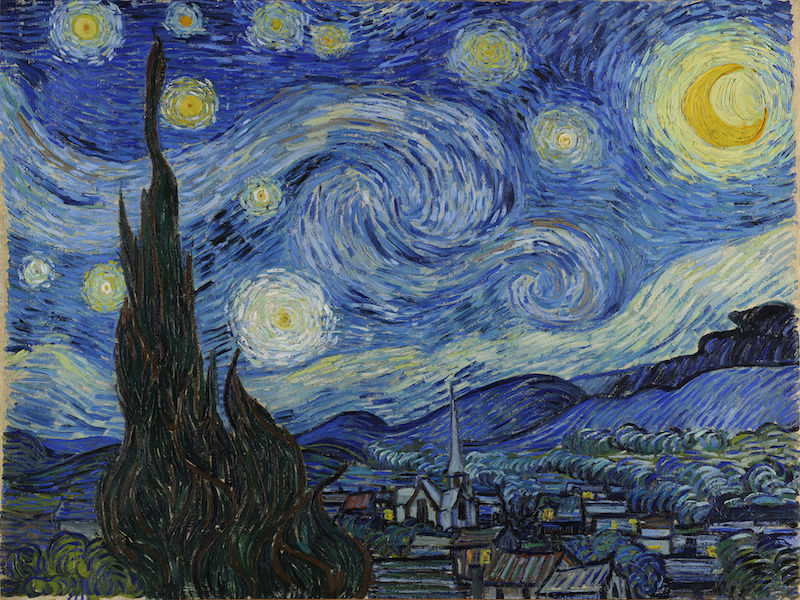

In [29]:
display_array(style)

In [14]:
# compute layer activations for content
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    content_pre = np.array([network_model.preprocess(content)])

    image = tf.placeholder('float', shape=content_pre.shape)
    model = network_model.get_model(image)
    content_out = sess.run(model[content_layer], feed_dict = {image:content_pre})

In [15]:
# compute layer activations for style
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    style_pre = np.array([network_model.preprocess(style)])
    image = tf.placeholder('float', shape=style_pre.shape)
    model = network_model.get_model(image)
    style_out = sess.run({s_l:model[s_l] for s_l in style_layer}, feed_dict = {image:style_pre})

In [16]:
now = datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")
logdir = "logs"

In [17]:
g = tf.Graph()
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # init randomly
    # white noise
    target = tf.random_normal((1,)+content.shape)

    target_pre_var = tf.Variable(target)

    # build model with empty layer activations for generated target image
    model = network_model.get_model(target_pre_var)

    # compute loss
    cont_cost = content_loss(content_out, model, content_layer, content_weight)
    style_cost = style_loss(style_out, model, style_layer, style_weight_layer)
    tv_cost = total_var_loss(target_pre_var, tv_weight)

    total_loss = cont_cost + tf.add_n(style_cost) + tv_cost

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

    sess.run(tf.global_variables_initializer())
    min_loss = float("inf")
    best = None
    for step in range(iterations):
        train_step.run()
        print('Iteration %d/%d' % (step + 1, iterations))

        if step % 5 == 0:
            loss = total_loss.eval()
            print('total loss: %g' % total_loss.eval())
            if(loss < min_loss):
                min_loss = loss
                best = target_pre_var.eval()

    print('content loss: %g' % cont_cost.eval())
    print('style loss: %g' % tf.add_n(style_cost).eval())
    print('tv loss: %g' % tv_cost.eval())
    print('total loss: %g' % total_loss.eval())

Iteration 1/5
total loss: 7.54643e+11
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
content loss: 6.97294e+10
style loss: 6.31721e+11
tv loss: 0
total loss: 7.01451e+11


In [18]:
with_style = best
with_style = with_style.squeeze()
with_style = network_model.postprocess(final)
with_style = np.clip(final, 0, 255).astype(np.uint8)

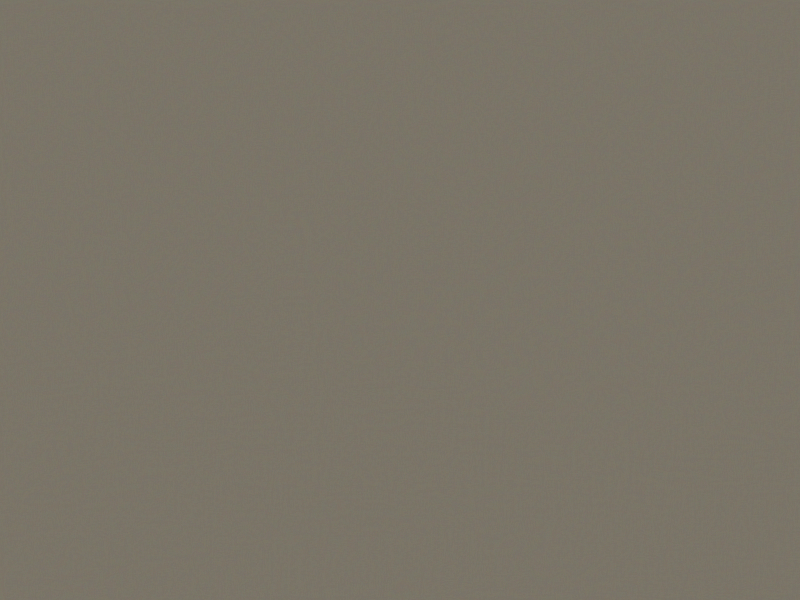

In [20]:
display_array(final)